In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for kpss
import plotly.graph_objects as go
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from plotly.subplots import make_subplots
from arch import arch_model

warnings.filterwarnings("ignore")

In [2]:
start = "1994-01-01"
end = "1996-12-31"
start_test = "1997-01-01"
end_test = "2024-04-21"

df_vix_raw = yf.download("^VIX", "1993-12-25", end_test)
df_gspc_raw = yf.download("^GSPC", "1993-12-25", end_test)

df_vix_raw.columns = df_vix_raw.columns.str.lower()
df_gspc_raw.columns = df_gspc_raw.columns.str.lower()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_vix_raw['diff_1'] = df_vix_raw['close'].diff(1)
df_vix = df_vix_raw.loc[start:end].copy()
df_vix_test = df_vix_raw.loc[start_test:end_test].copy()

In [4]:
df_gspc_raw["adj close_shift_1"] = df_gspc_raw["adj close"].shift(1)
df_gspc_raw["log_return"] = np.log(
    df_gspc_raw["adj close"] / df_gspc_raw["adj close_shift_1"]
)
df_gspc_raw["simple_return"] = df_gspc_raw["adj close"].pct_change() * 100
df_gspc_raw = df_gspc_raw.dropna()

In [5]:
df_gspc = df_gspc_raw.loc[start:end].copy()
df_gspc_test = df_gspc_raw.loc[start_test:end_test].copy()

In [6]:
# EDA CHECK
pd.DataFrame.equals(df_vix["close"], df_vix["adj close"])

True

In [7]:
df_vix

,open,high,low,close,adj close,volume,diff_1
Date,,,,,,,
1994-01-03,11.280000,13.420000,11.280000,12.570000,12.570000,0,0.910000
1994-01-04,12.870000,12.870000,11.810000,11.910000,11.910000,0,-0.660000
1994-01-05,11.470000,11.470000,10.370000,10.940000,10.940000,0,-0.970000
1994-01-06,11.470000,11.740000,10.340000,11.270000,11.270000,0,0.330001
1994-01-07,11.470000,12.140000,10.000000,10.960000,10.960000,0,-0.310000
...,...,...,...,...,...,...,...
1996-12-24,19.219999,19.219999,18.680000,18.680000,18.680000,0,-0.820000
1996-12-26,18.330000,18.709999,18.190001,18.590000,18.590000,0,-0.090000
1996-12-27,18.670000,19.129999,18.670000,19.129999,19.129999,0,0.539999


In [8]:
df_vix_test

,open,high,low,close,adj close,volume,diff_1
Date,,,,,,,
1997-01-02,21.540001,22.799999,21.100000,21.139999,21.139999,0,0.219999
1997-01-03,19.820000,19.920000,19.040001,19.129999,19.129999,0,-2.010000
1997-01-06,19.840000,20.440001,19.420000,19.889999,19.889999,0,0.760000
1997-01-07,20.459999,20.709999,19.309999,19.350000,19.350000,0,-0.539999
1997-01-08,18.600000,20.530001,18.600000,20.240000,20.240000,0,0.889999
...,...,...,...,...,...,...,...
2024-04-15,16.940001,19.459999,16.260000,19.230000,19.230000,0,1.920000
2024-04-16,19.490000,19.559999,17.639999,18.400000,18.400000,0,-0.830000
2024-04-17,18.240000,19.110001,17.540001,18.209999,18.209999,0,-0.190001


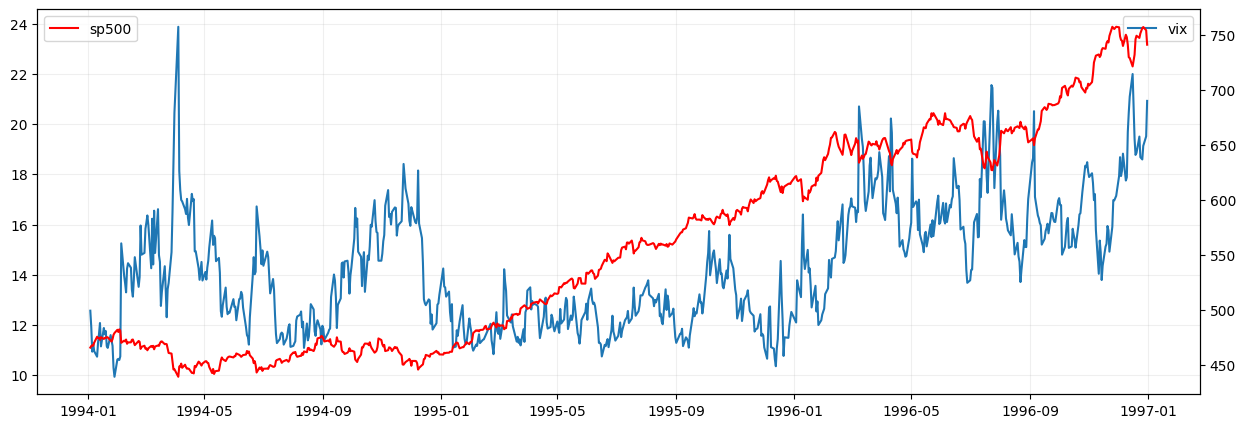

In [9]:
plt.figure(figsize=(15, 5))
plt.grid(alpha=0.2)
plt.plot(df_vix["close"], label="vix")
plt.legend(loc=0)
plt.gca().twinx().plot(df_gspc["close"], color="red", label="sp500")
plt.legend()
plt.show()

# 1. CHECK STATIONARY
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [10]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [11]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [12]:
# NULL = STATIONARY
# ALTERNATE = NON STATIONARY
kpsstest = kpss_test(df_vix['close'])

# Can reject NULL at 95% confidence interval
# The series is not stationary according to the KPSS test

Results of KPSS Test:
Test Statistic            1.533362
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [13]:
# NULL = non stationary
# ALTERNATE = STATIONARY
adftest = adf_test(df_vix['close'])

# Can reject NULL at 95% and 99% confidence interval
# The series has no unit root. (series is stationary)

Results of Dickey-Fuller Test:
Test Statistic                  -3.228673
p-value                          0.018384
#Lags Used                       4.000000
Number of Observations Used    753.000000
Critical Value (1%)             -3.439064
Critical Value (5%)             -2.865386
Critical Value (10%)            -2.568818
dtype: float64


In [14]:
kpsstest = kpss_test(df_vix['diff_1'])


Results of KPSS Test:
Test Statistic            0.06806
p-value                   0.10000
Lags Used                24.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


In [15]:
adftest = adf_test(df_vix['diff_1'])


Results of Dickey-Fuller Test:
Test Statistic                -1.103197e+01
p-value                        5.638542e-20
#Lags Used                     1.000000e+01
Number of Observations Used    7.470000e+02
Critical Value (1%)           -3.439134e+00
Critical Value (5%)           -2.865417e+00
Critical Value (10%)          -2.568834e+00
dtype: float64


It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

seems to be case 4 on VIX only, case 2 on diff 1!


# ACF TEST

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

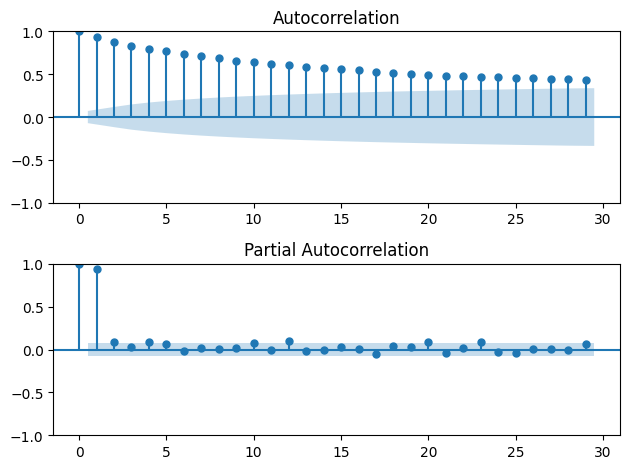

In [17]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_vix["close"], ax=ax[0])
plot_pacf(df_vix["close"], ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

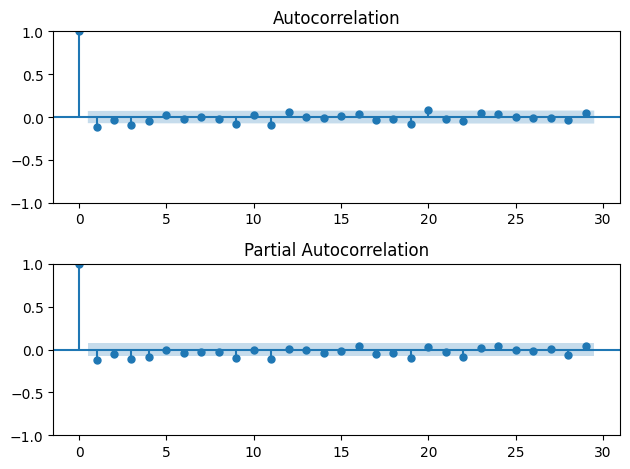

In [18]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_vix["diff_1"], ax=ax[0])
plot_pacf(df_vix["diff_1"], ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

# 1B. AR(1) MODEL FOR VIX

In [19]:
def arima_model(train_data,test_data, p,d,q):
    """
    ARIMA MODEL 1 DAY FORECAST HORIZON
    """
    model=ARIMA(train_data,order=(p,d,q))
    res=model.fit()
    print(res.summary())
    # ar_params = res.arparams
    # ma_params = res.maparams
    # print(f"AR PARAMS : {ar_params}")
    # print(f"MA PARAMS : {ma_params}")

    testing = pd.concat([train_data, test_data])
    prediction = []

    # 1 DAY ROLLING
    for i in range(len(train_data), len(train_data) + len(test_data)):
        updated_res = res.apply(testing[:i])
        prediction.append(updated_res.forecast(1).iloc[0])

    predictions = pd.DataFrame(
        {
            "AR": prediction,
            "Actual": test_data,
        }
    )
    print(
        f" Mean Abs Percentage Error(%) :{mean_absolute_percentage_error(test_data, prediction) * 100} %"
    )
    print(f"in sample mean ARIMA({p},{d},{q}) :{(predictions.iloc[0:len(train_data)]['AR']).mean()}")
    print(f"in sample std ARIMA({p},{d},{q}) :{(predictions.iloc[0:len(train_data)]['AR']).std()}")

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_vix_test.index, y=test_data, mode="lines", name="VIX CLOSE"
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_vix_test.index, y=prediction, mode="lines", name=f"ARIMA({p},{d},{q})"
        )
    )
    fig.update_layout(title=f"VIX & ARIMA({p},{d},{q} FORECAST")
    fig.show()
    return predictions


In [ ]:
def rolling_arima(train_data, test_data, p,d,q):
    # ROLLING FORECAST , THANK YOU YOUTUBE MAN
    # https://www.youtube.com/watch?v=NKHQiN-08S8
    # 1 DAY FORECAST HORIZON
    rolling_pred =[]
    test_size = len(test_data)

    for i in range(test_size):
        the_data = pd.concat([train_data, test_data])
        train = the_data[i:-(test_size-i)]
        model = ARIMA(train,order=(p,d,q))
        res = model.fit()
        rolling_pred.append(res.forecast(1).iloc[0])
    rolling_pred = pd.Series(rolling_pred, index = test_data.index)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(x=test_data.index, y=test_data, mode="lines", name="VIX CLOSE"),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=rolling_pred.index,
            y=rolling_pred,
            mode="lines",
            name="FORECAST VIX",
        ),
        secondary_y=False,
    )
    fig.update_layout(title=f"ACTUAL VIX and ROLLING ARIMA({p},{d},{q}) 1-DAY FORECAST VIX")
    fig.show()
    print(f" Mean Abs Percentage Error(%) vs VIX:{mean_absolute_percentage_error(test_data, rolling_pred)*100} %")
    return rolling_pred


In [21]:
def generate_hedge_signal(prediction_series, threshold):
    df_work = pd.DataFrame(prediction_series,columns=['pred_vix'])
    df_work['upper_thresh'] =threshold
    df_work['exceed_thresh'] = df_work['pred_vix']>df_work['upper_thresh']
    df_work['exceed_thresh'] = df_work['exceed_thresh'].astype(int)
    df_work['diff_exceed_thresh'] = df_work['exceed_thresh'].diff()
    df_work['hedge_signal'] = df_work['diff_exceed_thresh'].shift(1)
    df_work['hedge_signal'] = df_work['hedge_signal'].replace(-1,0)
    df_work =df_work.fillna(0)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(x=df_work.index, y=df_work['pred_vix'], mode="lines", name="pred"),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=df_work.index,
            y=df_work['hedge_signal'],
            mode="markers",
            name="hedge event",
        ),
        secondary_y=True,
    )
    fig.update_layout(title=f"Prediction & Hedge Event")
    fig.show()
    return df_work

In [22]:
mean_94_96 = df_vix['close'].mean()
std_94_96 = df_vix['close'].std()

In [23]:
arima_100 = rolling_arima(df_vix["close"].iloc[-20:],df_vix_test["close"],1,0,0)

KeyboardInterrupt: 

In [ ]:
print(mean_94_96 + 10 * std_94_96)

In [ ]:
df_work_arima_100 = generate_hedge_signal(arima_100,mean_94_96 + 10 * std_94_96)
df_work_arima_100.to_csv("arima100.csv")

In [ ]:
arima_010 =rolling_arima(df_vix["close"].iloc[-20:],df_vix_test["close"],0,1,0)

In [ ]:
df_work_arima_010 = generate_hedge_signal(arima_010,mean_94_96 + 10 * std_94_96)
df_work_arima_010.to_csv("arima010.csv")

# 2. GARCH ON GSCP SIMPLE RETURN - CAN IGNORE

Note Simple Return is percentage

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_gspc["simple_return"]**2, ax=ax[0])
plot_pacf(df_gspc["simple_return"]**2, ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

In [ ]:
kpss_gspc = kpss_test(df_gspc["simple_return"]**2)

In [ ]:
adf_gspc = adf_test(df_gspc["simple_return"]**2)

In [ ]:
# START FROM 2,2, ONE OF THE COEFFICIENT IS DOGSHIT BUT WHATEVER, YOU WANT TO FIT YOU FALL INTO THE REALM OF SUSSY P HACKING
am = arch_model(df_gspc["simple_return"], p =5, q =5)
res = am.fit(update_freq=5)
print(res.summary())

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_gspc["simple_return"].index, y=df_gspc["simple_return"], mode="lines", name="simple return ^GSPC"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252),
        mode="lines",
        name="IN SAMPLE GARCH VOL",
    ),
    secondary_y=True,
)
fig.update_layout(title="Simple Return (percentage) and GARCH(2,2) In Sample Vol")
fig.show()

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_vix.index, y=df_vix["close"], mode="lines", name="VIX CLOSE"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252),
        mode="lines",
        name="IN SAMPLE GARCH VOL",
    ),
    secondary_y=False,
)
fig.update_layout(title="VIX and GARCH(2,2) In Sample Vol")
fig.show()
print(f"in sample mean GARCH(2,2) :{(res.conditional_volatility * np.sqrt(252)).mean()}")
print(f"in sample std GARCH(2,2) :{(res.conditional_volatility * np.sqrt(252)).std()}")

In [ ]:
# ROLLING FORECAST , THANK YOU YOUTUBE MAN
# https://www.youtube.com/watch?v=NKHQiN-08S8
# 1 DAY FORECAST HORIZON
def rolling_garch(train_data, test_data, p,q):
    rolling_pred =[]
    test_size = len(test_data)

    for i in range(test_size):
        the_data = pd.concat([train_data, test_data])
        train = the_data[:-(test_size-i)]
        model = arch_model(train["simple_return"], p =p, q =q)
        res = model.fit(disp= 'off')
        pred = res.forecast(horizon=1)
        rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))
    rolling_pred = pd.Series(rolling_pred, index = test_data.index)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(x=test_data.index, y=test_data, mode="lines", name="VIX CLOSE"),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=rolling_pred.index,
            y=rolling_pred * np.sqrt(252),
            mode="lines",
            name="OUT SAMPLE GARCH VOL",
        ),
        secondary_y=False,
    )
    fig.update_layout(title=f"VIX and GARCH({p},{q}) In Sample Vol")
    fig.show()
    print(f" Mean Abs Percentage Error(%) vs VIX:{mean_absolute_percentage_error(test_data, rolling_pred)*100} %")


In [ ]:

rolling_garch